In [1]:
%cd ..

c:\Users\ADMIN\Downloads\BTL2ML


In [ ]:
# !git clone https://github.com/Thien-lee-44/BTL2_ML251.git
# %cd BTL2_ML251

In [2]:
import numpy as np
import pandas as pd
import random
import kagglehub
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
import torch
import sys, os
# models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from transformers import AutoTokenizer, AutoModel,BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'modules')

# Thêm vào PYTHONPATH
sys.path.append("..")
from modules.module import*
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("djdonpablo/poem-classification-dataset")
print("Download and Load data at: " + path)

Download and Load data at: C:\Users\ADMIN\.cache\kagglehub\datasets\djdonpablo\poem-classification-dataset\versions\1


In [4]:
df = pd.read_csv(path + '/data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,unnamed:_0,poem,topic
0,0,Sunday we lay hands\non a girl of ten hand on ...,religion
1,1,O transient voyager of heaven!\n⁠ ⁠ ⁠ O silent...,religion
2,2,\n\n\na cento for Sarah Hegazy\n\n\n\n\na cent...,religion
3,3,"I am in the middle of “The Fourteen Poems"" by ...",religion
4,4,"I lift him out, whole and perfect.\nSaid told ...",religion


In [5]:
df.info() # No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10064 entries, 0 to 10063
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   unnamed:_0  10064 non-null  int64 
 1   poem        10064 non-null  object
 2   topic       10064 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.0+ KB


In [6]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape) # No duplicated code found

number of duplicate rows:  (0, 3)


In [7]:
# Plot distribution of poem's topic

topic_percent = df['topic'].value_counts(normalize=True) * 100
print(topic_percent)

topic
nature           24.135533
arts&sciences    21.691176
love             20.687599
relationships    17.955087
religion         15.530604
Name: proportion, dtype: float64


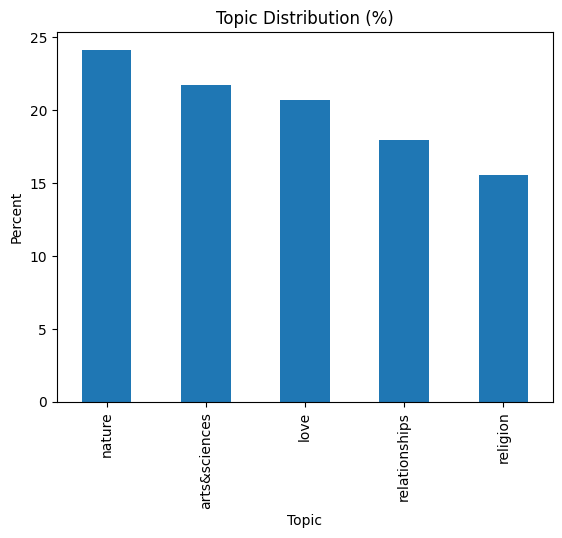

In [8]:
topic_percent.plot(kind='bar')
plt.title("Topic Distribution (%)")
plt.xlabel("Topic")
plt.ylabel("Percent")
plt.show()

# Conclusion, fairly balanced, with nature being the most and religion being the least

In [6]:
df["poem"] = df["poem"].apply(clean_text)

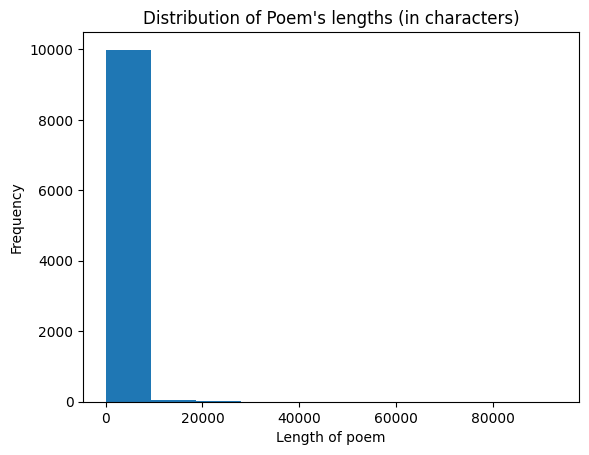

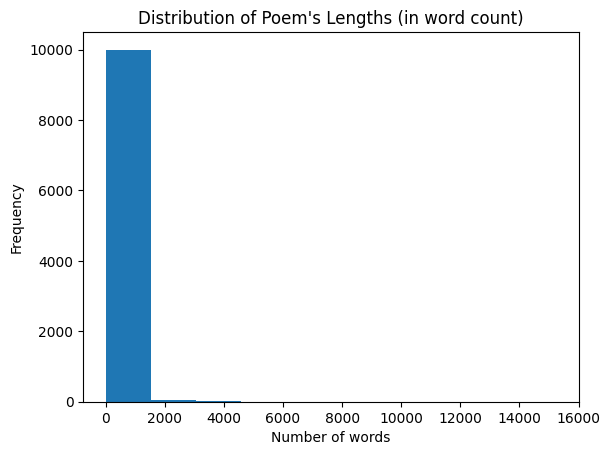

In [10]:
# Plot distribution of poem's length

df["poem_length"] = df["poem"].str.len()
df["word_count"] = df["poem"].str.split().str.len()

plt.hist(df["poem_length"], bins=10)  # adjust bins depending on data
plt.title("Distribution of Poem's lengths (in characters)")
plt.xlabel("Length of poem")
plt.ylabel("Frequency")
plt.show()

plt.hist(df["word_count"], bins=10)
plt.title("Distribution of Poem's Lengths (in word count)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# Conclusion, a lot of poems are near 10k characters and words

      word  count
42     one   9394
182   will   6382
276    now   5809
217   love   5285
194     us   5129
245   time   4152
89    know   4107
37    back   4081
227    see   4058
119  still   3770


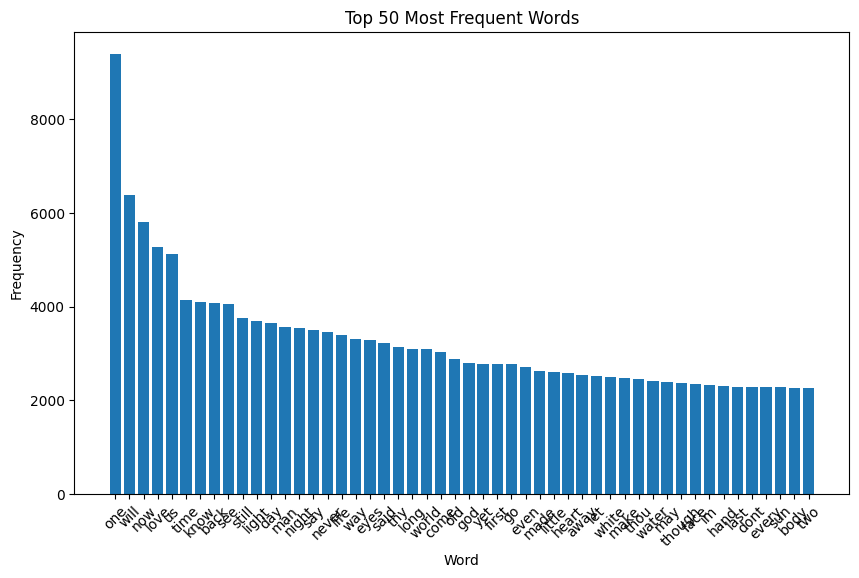

In [11]:
# Plot word frequency
# "the" is expected to be the most common word

all_poems = " ".join(df["poem"]).split()
word_counter = Counter(all_poems)
word_freq = pd.DataFrame(
    word_counter.items(),
    columns=["word", "count"]
).sort_values(by="count", ascending=False)

print(word_freq.head(10))

top_n = 50
plt.figure(figsize=(10,6))
plt.bar(word_freq["word"].head(top_n), word_freq["count"].head(top_n))
plt.title(f"Top {top_n} Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Conclusion: The distribution very closely follows the actual distribution for the english language

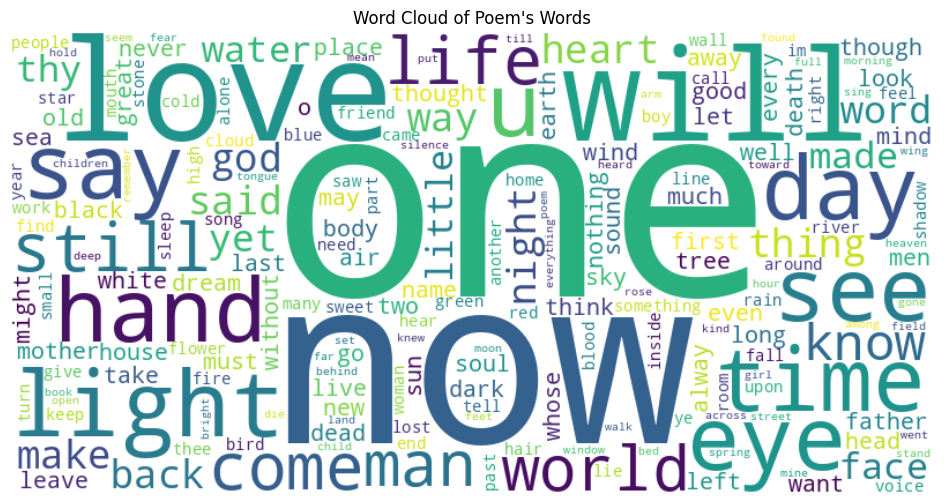

In [13]:
# Word cloud

wc = WordCloud(width=800, height=400,
               background_color="white",
               stopwords=set(STOPWORDS),
               colormap="viridis").generate(" ".join(all_poems))

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Poem's Words")
plt.show()

# Conclusion : one, love and now is super big

In [14]:
# N-grams analysis

vectorizer = CountVectorizer(ngram_range=(2,4), stop_words = "english") # data contains latin / archaic english, but just english for now to avoid so many the
X = vectorizer.fit_transform(df["poem"])
ngram_freq = X.sum(axis=0).A1
ngrams = vectorizer.get_feature_names_out()
ngram_df = pd.DataFrame({"ngram": ngrams, "count": ngram_freq})
ngram_df = ngram_df.sort_values(by="count", ascending=False)

print(ngram_df.head(20))

               ngram  count
813212     dont know    404
3249424     thou art    227
3716710    years ago    217
2152037     new york    191
1897086    love love    154
1019288     far away    151
2214047      old man    150
3251468    thou hast    146
816006     dont want    143
765945    didnt know    140
1860713    long time    134
694849       day day    130
1854598     long ago    129
698314     day night    121
1682753    know know    111
3300318    time time     95
1619961     ive seen     91
3253476   thou shalt     89
3718847  years later     87
1363630    hand hand     80


In [17]:
#TF-IDF analysis

vectorizer =  vectorizer = TfidfVectorizer(
    max_features=20000,     
    ngram_range=(1, 2),    
    min_df=3,              
    max_df=0.8,             
    sublinear_tf=True,       
    stop_words='english',   
    norm='l2'     
    )   
X = vectorizer.fit_transform(df["poem"]).toarray()
tfidf_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
tfidf_df["topic"] = df["topic"].values
class_tfidf = tfidf_df.groupby("topic").mean()

for c in class_tfidf.index:
    print(f"\nTop distinctive terms for class '{c}':")
    display(class_tfidf.loc[c].sort_values(ascending=True).head(10))


Top distinctive terms for class 'arts&sciences':


entomb           0.0
fie              0.0
magpies          0.0
holiness         0.0
yeve             0.0
acre             0.0
brands           0.0
branch branch    0.0
brakes           0.0
braided hair     0.0
Name: arts&sciences, dtype: float64


Top distinctive terms for class 'love':


youve seen      0.0
encased         0.0
encountered     0.0
acacias         0.0
academy         0.0
accelerating    0.0
acceptable      0.0
encrusted       0.0
religions       0.0
remaind         0.0
Name: love, dtype: float64


Top distinctive terms for class 'nature':


yr             0.0
patrons        0.0
fierie         0.0
fiendish       0.0
aboute         0.0
resemblance    0.0
lay head       0.0
zion           0.0
epistle        0.0
kan            0.0
Name: nature, dtype: float64


Top distinctive terms for class 'relationships':


merged         0.0
matin          0.0
matt           0.0
mercurial      0.0
accumulated    0.0
accurst        0.0
achievement    0.0
memoir         0.0
fullblown      0.0
compard        0.0
Name: relationships, dtype: float64


Top distinctive terms for class 'religion':


yr              0.0
zummer          0.0
heater          0.0
aba             0.0
rimbaud         0.0
abuelo          0.0
scaffolding     0.0
played piano    0.0
platters        0.0
bounce          0.0
Name: religion, dtype: float64

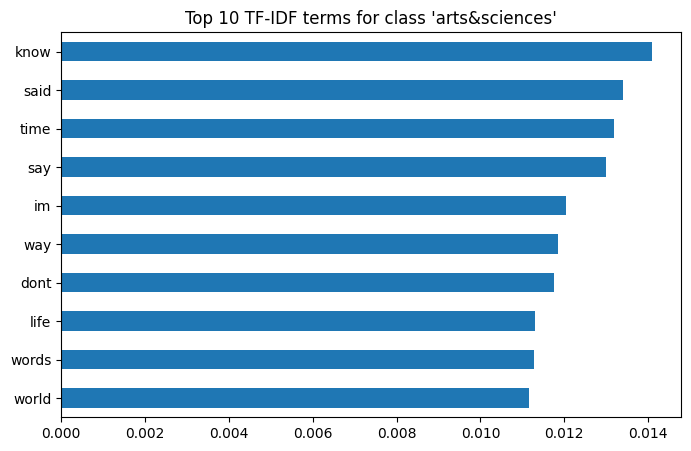

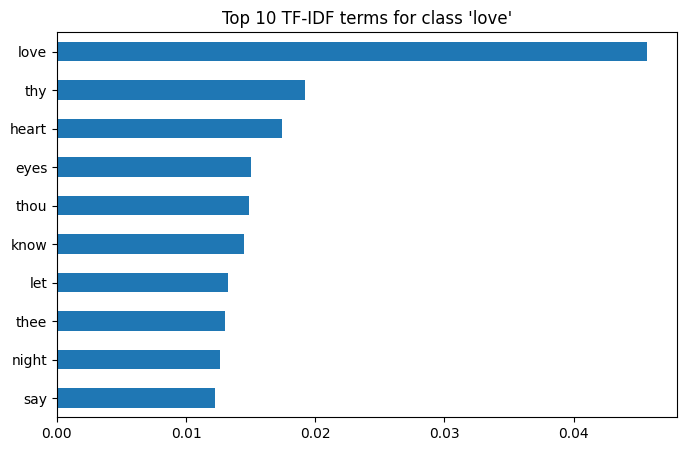

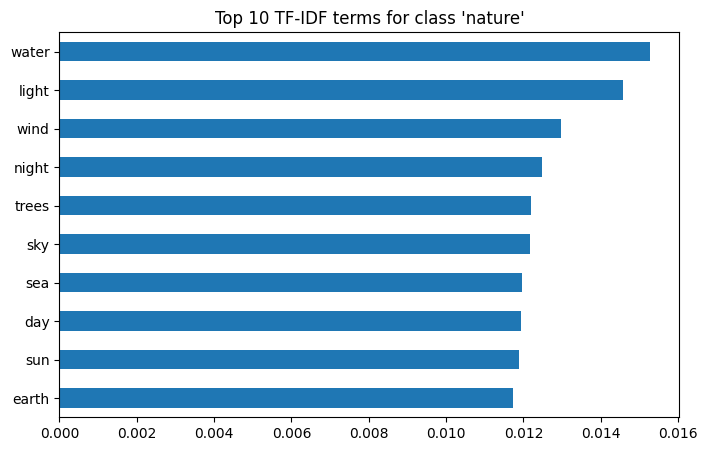

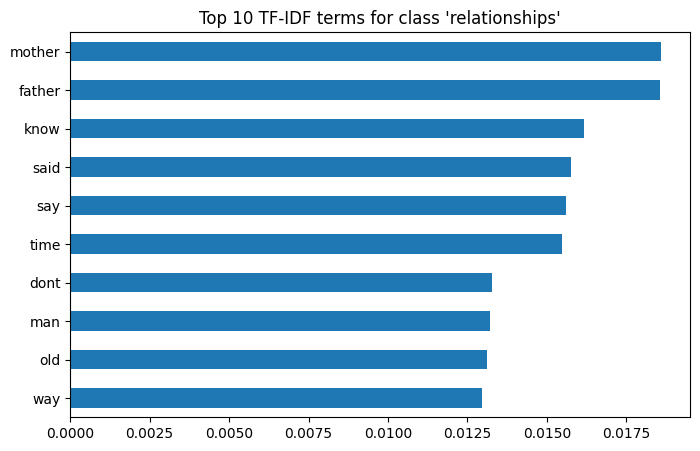

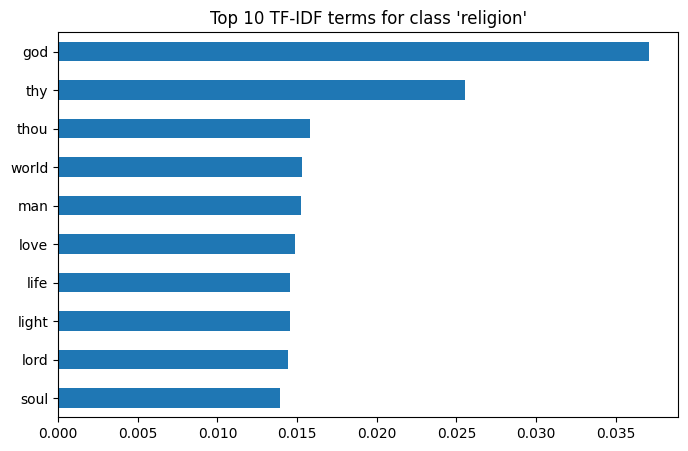

In [16]:
top_n = 10
for c in class_tfidf.index:
    top_terms = class_tfidf.loc[c].sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8,5))
    top_terms.plot(kind="barh")
    plt.title(f"Top {top_n} TF-IDF terms for class '{c}'")
    plt.gca().invert_yaxis()
    plt.show()

In [18]:
le=LabelEncoder()
y=le.fit_transform(df['topic'])

Training Logistic Regression


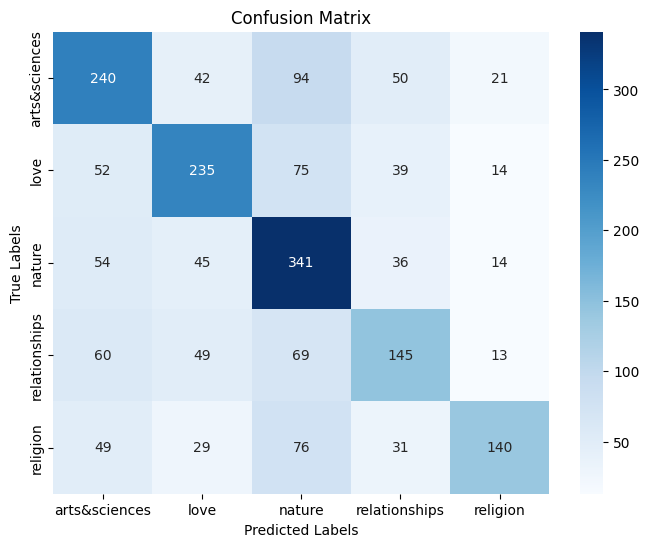


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.53      0.54      0.53       447
         love       0.59      0.57      0.58       415
       nature       0.52      0.70      0.60       490
relationships       0.48      0.43      0.46       336
     religion       0.69      0.43      0.53       325

     accuracy                           0.55      2013
    macro avg       0.56      0.53      0.54      2013
 weighted avg       0.56      0.55      0.54      2013

Training SVM


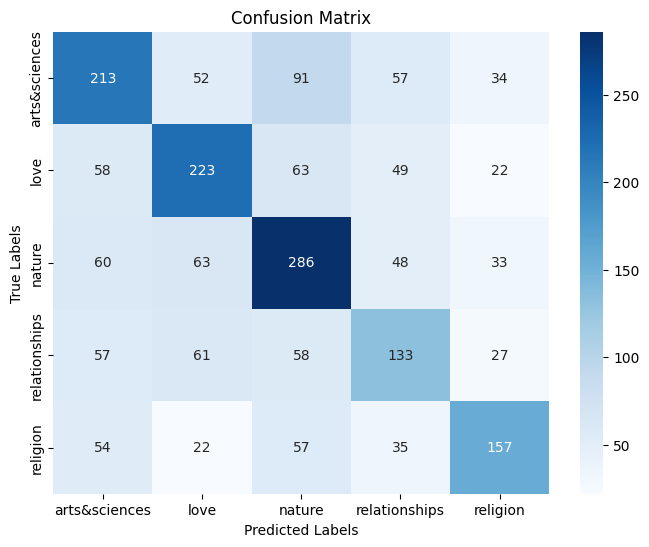


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.48      0.48      0.48       447
         love       0.53      0.54      0.53       415
       nature       0.52      0.58      0.55       490
relationships       0.41      0.40      0.40       336
     religion       0.58      0.48      0.53       325

     accuracy                           0.50      2013
    macro avg       0.50      0.50      0.50      2013
 weighted avg       0.50      0.50      0.50      2013

Training Naive Bayes


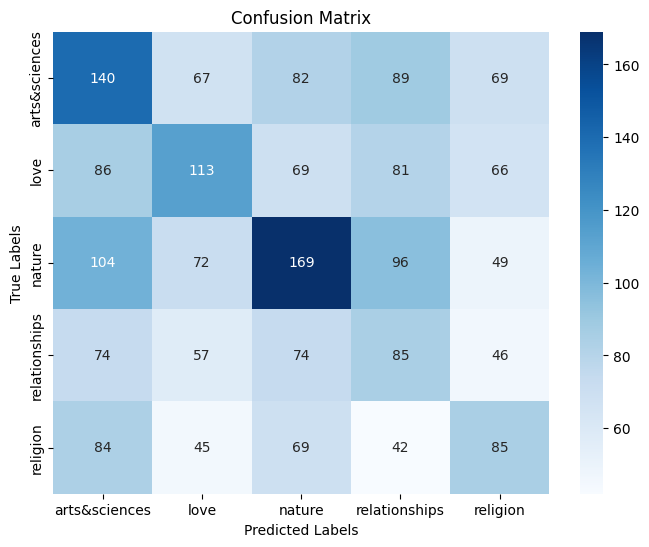


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.29      0.31      0.30       447
         love       0.32      0.27      0.29       415
       nature       0.37      0.34      0.35       490
relationships       0.22      0.25      0.23       336
     religion       0.27      0.26      0.27       325

     accuracy                           0.29      2013
    macro avg       0.29      0.29      0.29      2013
 weighted avg       0.30      0.29      0.30      2013



In [19]:
simpleModel(X,y,le)

In [ ]:
X,y,le=BERT(df['poem'],df['topic'])

Training Logistic Regression


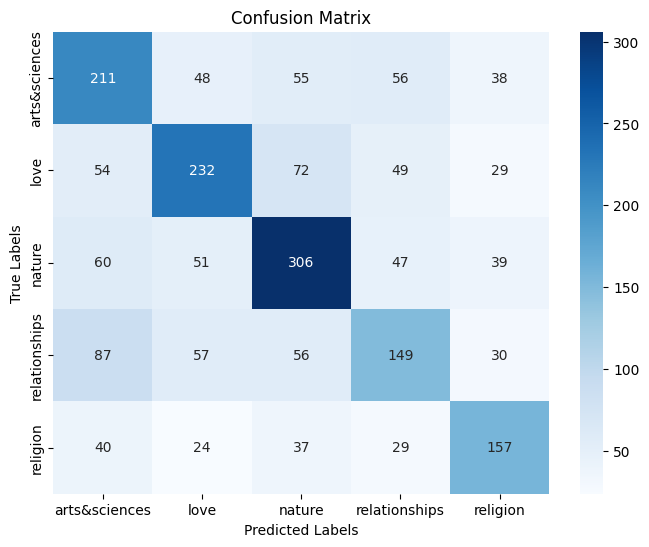


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.47      0.52      0.49       408
         love       0.56      0.53      0.55       436
       nature       0.58      0.61      0.59       503
relationships       0.45      0.39      0.42       379
     religion       0.54      0.55      0.54       287

     accuracy                           0.52      2013
    macro avg       0.52      0.52      0.52      2013
 weighted avg       0.52      0.52      0.52      2013

Training SVM


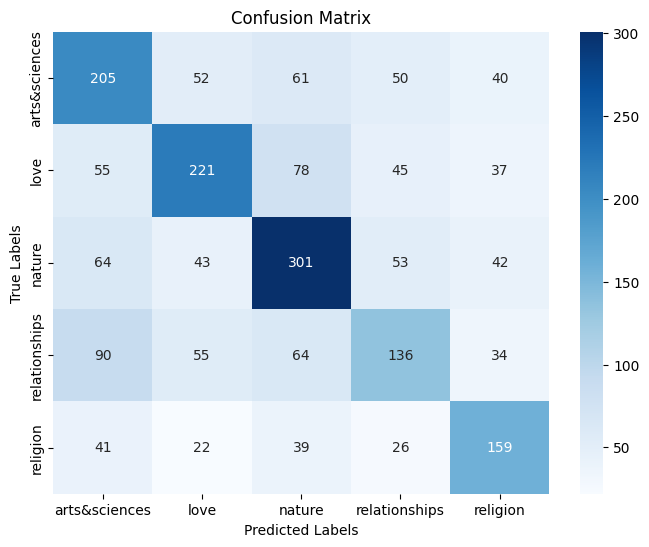


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.45      0.50      0.48       408
         love       0.56      0.51      0.53       436
       nature       0.55      0.60      0.58       503
relationships       0.44      0.36      0.39       379
     religion       0.51      0.55      0.53       287

     accuracy                           0.51      2013
    macro avg       0.50      0.50      0.50      2013
 weighted avg       0.51      0.51      0.51      2013

Training Naive Bayes


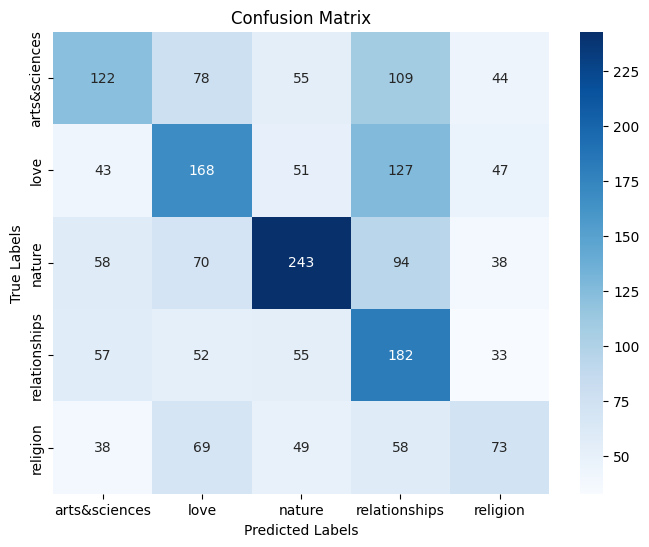


 Classification Report:

               precision    recall  f1-score   support

arts&sciences       0.38      0.30      0.34       408
         love       0.38      0.39      0.38       436
       nature       0.54      0.48      0.51       503
relationships       0.32      0.48      0.38       379
     religion       0.31      0.25      0.28       287

     accuracy                           0.39      2013
    macro avg       0.39      0.38      0.38      2013
 weighted avg       0.40      0.39      0.39      2013



In [8]:
simpleModel(X,y,le)

In [ ]:
finetuneBERT(df['poem'],df['topic'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
